In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

In [102]:
df_clinical = pd.read_csv('clinical.csv')
df_genomics = pd.read_csv('genomics.csv')

In [103]:
# Checking for duplicate rows in dataframe
print(np.unique(df_clinical.duplicated()))
print(np.unique(df_genomics.duplicated()))

[False]
[False]


### Visualizing correlation between features
We can first try visualizing data by plotting a pairplot. However, there is not much significant trends seen since most features are categorical and sparsly scattered.

From the correlation matrix, we can see that the highest correlation is the number of mutated genes and number of mutations. This is because the definition of the two features are fairly similar.
We can also see that there is not much strong correlation directly between all features.

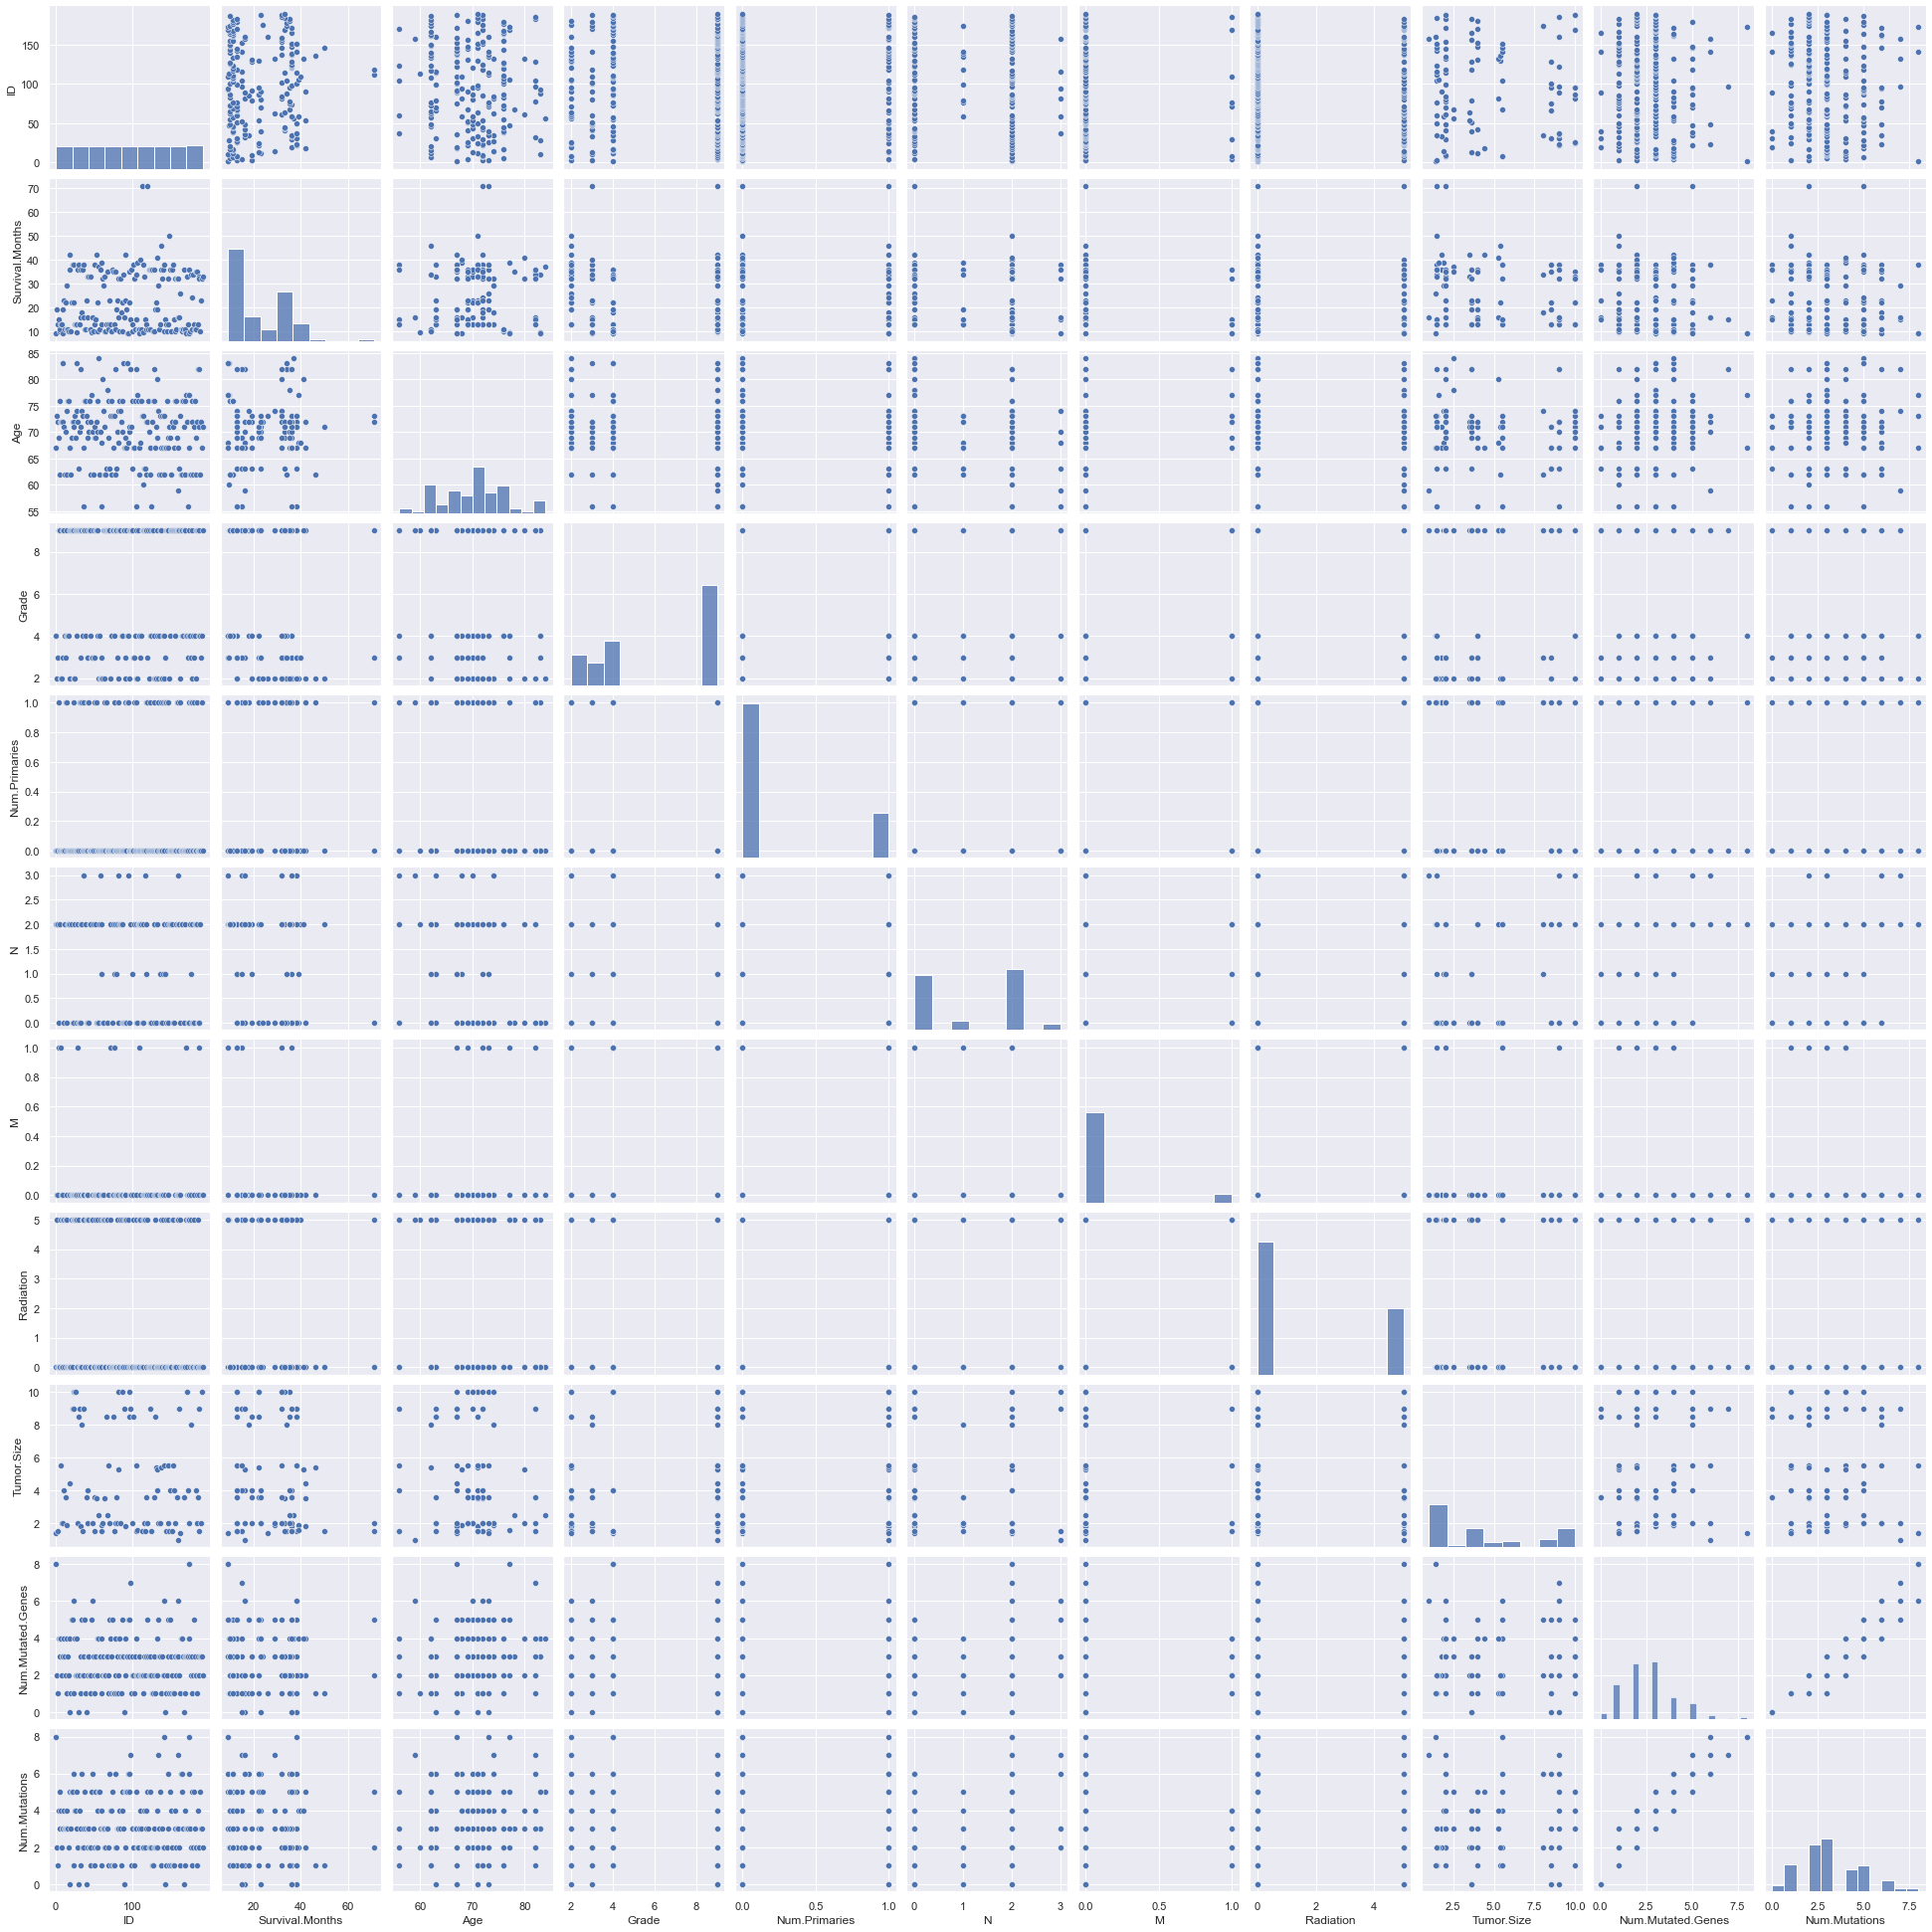

In [104]:
sns.pairplot(df_clinical)
plt.show()

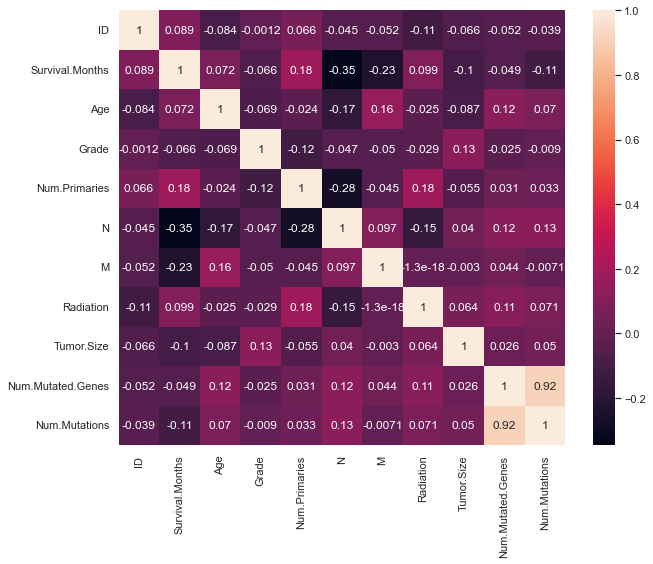

In [105]:
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
corr = df_clinical.corr()
sns.heatmap(corr, annot=True)
plt.show()

To combine the given genomics data and create new features, a left join is performed on the original dataframe (df_clinical) and the newly created genomic dataframe (df_dummies).
After merging, we can start performing data cleaning procedures.

In [106]:
list = []
df_genomics = pd.get_dummies(df_genomics).sort_values('ID')
for i in np.unique(df_genomics.ID):
    temp = df_genomics[df_genomics.ID == i]
    list.append(np.sum(temp.iloc[:, 1:-1]))

df_dummies = pd.DataFrame(list)
df_dummies['ID'] = np.unique(df_genomics.ID)

# Left joining the newly created dataframe and the original dataframe.
left_merged = pd.merge(df_clinical, df_dummies, on=["ID"], how='left')
left_merged.loc[:, 'Gene_AKT1':'Gene_TP53_Col2'] = left_merged.loc[:, 'Gene_AKT1':'Gene_TP53_Col2'].fillna(0)

The objective of this project is to build and evaluate a predictive model of one-year survival after diagnosis with NSCLC. We can generate the ground truth labels by evaluating the columns ['Outcome', 'Survival. Months']. However, cases where the survival months < 12 and are also alive must be eliminated in the analysis since we don't know whether these cases actually survived after 1 year.

In [107]:
# Extracting the relevant dataframe
idx = left_merged[ (left_merged['Outcome'] == 'Alive') & (left_merged['Survival.Months'] < 12) ].index
left_merged.drop(idx , inplace=True)
left_merged = pd.get_dummies(left_merged, columns=['T','Stage','Primary.Site','Histology','Radiation'])

# Checking how many missing values exist in each column.
left_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 1 to 189
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 180 non-null    int64  
 1   Outcome                            180 non-null    object 
 2   Survival.Months                    180 non-null    float64
 3   Age                                180 non-null    int64  
 4   Grade                              180 non-null    int64  
 5   Num.Primaries                      180 non-null    int64  
 6   N                                  121 non-null    float64
 7   M                                  91 non-null     float64
 8   Tumor.Size                         97 non-null     float64
 9   Num.Mutated.Genes                  180 non-null    int64  
 10  Num.Mutations                      180 non-null    int64  
 11  Gene_AKT1                          180 non-null    float64

### Constructing the feature and labels
As we can see from the above, for features Tumor.Size, N, and M there are missing values. For this particular case, I dropped all three columns due to the high percentage of missing values. If there were a smaller percentage of missing values, I would try to either fill in with the mean/median values.

Num.Mutated.Genes was also dropped since it is a redundant feature. Other methods I would try to implement if I had more time would be applying linear regression between N and M to fill out the missing values accordingly.

For labels, patients whose survival months are lower than 12 and is also reported dead will be labeled as 1 (not survived after one year), while other cases will be labeled as 0 (survived after one year).

In [113]:
X = left_merged.drop(columns=['ID','Outcome','Survival.Months','N','M','Tumor.Size','Num.Mutated.Genes'])

y = np.zeros(180,)
y[(left_merged['Outcome'] == 'Dead') & (left_merged['Survival.Months'] < 12)] = 1
y

array([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])

### Machine Learning Model Construction

For the machine learning model, I chose to train a logistic regression model on the data using Stochastic Gradient Descent(SGD). This is because SGD is efficient and also has shown to be successfully applied to sparse data such as natural language processing.

To assess the performance of the machine learning model and also avoid overfitting, learning curves were plotted between the training and validation data set.

ROC curves were also plotted to evaluate the classifier output quality.

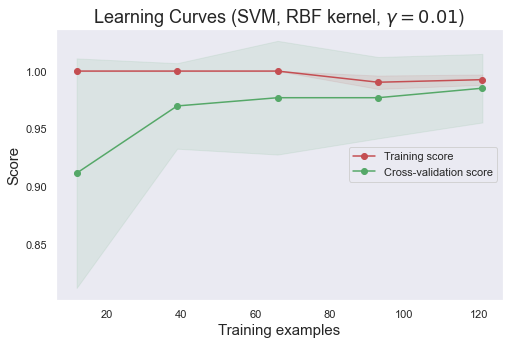

In [109]:
# Machine learning model initialization and applying cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

scaler = preprocessing.StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

estimator = SGDClassifier(loss='log', penalty='l1', class_weight='balanced', alpha=0.07)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator,
    X_train_sc,
    y_train,
    scoring='accuracy',
    cv=10,
    return_times=True,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

plt.title("Learning Curves (SVM, RBF kernel, $\gamma=0.01$)", fontsize=18)
plt.xlabel("Training examples", fontsize=15)
plt.ylabel("Score", fontsize=15)
plt.legend(loc="right")
plt.show()

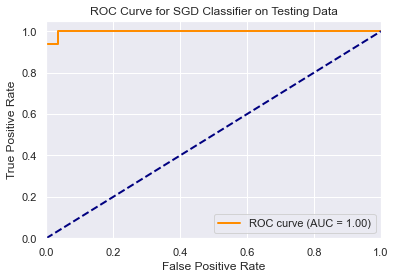

In [110]:
# Fitting the model
estimator.fit(X_train_sc, y_train)

# Plotting ROC curve
pred_prob = estimator.predict_proba(X_test_sc)
fpr, tpr, _ = roc_curve(y_test, pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SGD Classifier on Testing Data")
plt.legend(loc="lower right")
plt.show()

In [112]:
y_pred = estimator.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred)
print('Testing Accuracy: ' + str(acc*100) + ' %')

Testing Accuracy: 91.11111111111111 %


### Future Improvements
More data can be obtained that can improve classification performance such as demographic characteristics, smoking information(duration,intensity,etc), BMI data, or even chest x rays. With more data and time, I would want to apply more complex machine learning models such as XGBoost.